# Deep Zap-Q Learning

### Yann Bouteiller - Théo Moins - Dylan Troop

This notebook implements our adapted Deep Learning version of the Zap-Q Learning algorithm of Devraj and Meyn.

The code is a draft version adapted from the original Zap-Q learning python code that can be found at https://github.com/adidevraj .

In [0]:
# useful libraries

import numpy as np
import random
from numpy.linalg import inv
from numpy.linalg import pinv
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import copy
import random
import math
import time

In [0]:
# This part of the code implements live plotting:

class PlotResults():
    def __init__(self):
        self.time = []
        self.data = []
        self.iteration = []
    
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data_dict,
              title,
              ylabel=None,
              xlabel=None, figsize=(15,5),
              ylim1=None,
              clock_time1=True,
              data_dict2=None,
              title2=None,
              ylabel2=None,
              xlabel2=None,
              clock_time2=True,
              grid=True):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    if data_dict2:
        plt.subplot(1,2,1)
    for label,data in data_dict.items():
        if clock_time1:
            plt.plot(data.time,data.data,label=label)
        else:
            plt.plot(data.iteration,data.data,label=label)
    plt.title(title)
    plt.grid(grid)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(ylim1)
    plt.legend()
    if data_dict2:
        plt.subplot(1,2,2)
        for label,data in data_dict2.items():
            if clock_time2:
                plt.plot(data.time,data.data,label=label)
            else:
                plt.plot(data.iteration,data.data,label=label)
        plt.title(title2)
        plt.grid(grid)
        plt.xlabel(xlabel2)
        plt.ylabel(ylabel2)
        plt.legend()
    plt.show();

In [0]:
dataplot = collections.defaultdict(PlotResults)
dataplot2 = collections.defaultdict(PlotResults)

## Implementation of Deep Zap-Q

In this part we implement our first neural-network based version of Devraj and Meyn's algorithm

In [0]:
# defining the graph (weighted with rewards):

R = torch.FloatTensor([[0,-100,-100,-100,-5,-100],
                    [-100,0,-100,-5,-100,100],
                    [-100,-100,0,-5,-100,-100],
                    [-100,-5,-5,0,-5,-100],
                    [-5,-100,-100,-5,0,100],
                    [-100,-5,-100,-100,-5,100]])

# graph neighbors lists:

actionsList = []
actionsList.append(torch.IntTensor([0,4]))
actionsList.append(torch.IntTensor([1,3,5]))
actionsList.append(torch.IntTensor([2,3]))
actionsList.append(torch.IntTensor([1,2,3,4]))
actionsList.append(torch.IntTensor([0,3,4,5]))
actionsList.append(torch.IntTensor([1,4,5]))

num_SA = 2 + 3 + 2 + 4 + 4 + 3

In [0]:
def compute_Bellman_error(q_table, R, actionsList, nb_SA, beta, noise):
    """
    Computes the maximal Bellman Error of a Q table wrt the adjacency matrix R
    """
    
    #Initialize Bellman error to 0:
    BE = torch.zeros(nb_SA) # initialiser BE avec des 0
    i = 0
    for x, _ in enumerate(actionsList):
        for a in actionsList[x]:
            
            # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
            expectation_max_q_value = 0;
            nb_next_states = actionsList[x].shape[0];
            for aa in actionsList[x]:
                expectation_max_q_value = expectation_max_q_value + torch.max(q_table[aa])
            expectation_max_q_value = expectation_max_q_value/nb_next_states
            
            BE[i] = R[x,a] + beta*((1-noise)*torch.max(q_table[a]) +  noise*expectation_max_q_value) - q_table[x,a]
            i = i+1
            
    return torch.max(abs(BE))

In [0]:
def compute_max_real_part_eigenvalue(M): # computes the max real part of the eigenvalues of matrix M
    return np.max(np.real(np.linalg.eig(M)[0]))

In [0]:
def epsilon_greedy_policy(x, actionsList, Q, epsilon=0):
    """
    Returns action chosen according to an epsilon greedy policy
    Takes greedy action with proba 1-epsilon
    Q is the Zap_Q neural net used to approximate the Q function
    """
    
    # compute the best action
    
    def best_action(Q):
        nb_actions=actionsList[x].shape[0]
        Q_vals = torch.Tensor(nb_actions)
        for i in range(nb_actions):
            Q_vals[i] = Q.evaluateSA(x,actionsList[x][i])
        imax = torch.argmax(Q_vals)
        return actionsList[x][imax].item()
    
    # epsilon greedy policy: random action chosen with probability epsilon
    
    r = np.random.rand()
    if r > epsilon:
        return best_action(Q)
    else:
        return np.random.choice(actionsList[x])

In [0]:
# This part defines the reactions of the environment

def take_action(x, a, rewardMatrix, actionsList, randomness=0.5):
    """
    Environment's response to the action a taken from state x, returns: newState, reward
    """
    
    r = np.random.rand()
    if r > randomness:
        assert a in actionsList[x], "Error : the action in not possible"
        return a, rewardMatrix[x][a]
    else:
        a = np.random.choice(actionsList[x])
        return a, rewardMatrix[x][a]

In [0]:
# This part defines how we embbed a State-Action pair

nb_to_SA = torch.IntTensor([[0, 0],[0,4],
                            [1,1],[1,3],[1,5],
                            [2,2],[2,3],
                            [3,1],[3,2],[3,3],[3,4],
                            [4,0],[4,3],[4,4],[4,5],
                            [5,1],[5,4],[5,5]])

SA_to_nb = -1*torch.ones((6,6), dtype=torch.int)
for i in range(len(nb_to_SA)):
    i1 = nb_to_SA[i,0].item()
    i2 = nb_to_SA[i,1].item()
    SA_to_nb[i1,i2]=i

def SA_embedding(x, a):
    nb_SA = num_SA
    psi = torch.zeros(nb_SA)
    jj = SA_to_nb[x,a].item()
    psi[jj] = 1
    return psi

In [0]:
# Definition of our Deep Neural Network

class Q_function(nn.Module):
    def __init__(self, architecture):
        super(Q_function, self).__init__()
        self.net = architecture
    
    def input_size(self):
        return self.net.in_features
    
    def num_params(self):
        return sum(p.numel() for p in self.parameters())
        
    def forward(self, x):
        return self.net(x)
    
    def evaluate(self, x):
        with torch.no_grad():
            return self.net(x)
    
    def forwardSA(self, x, a): # to be improved: tensorize with lists of actions
        return self.forward(SA_embedding(x,a))
    
    def evaluateSA(self, x, a):
        with torch.no_grad():
            return self.forwardSA(x, a)
    
    def update_A_hat(self, A_hat, gamma, psi, psi_OptAct, beta):
        
        psi.requires_grad = True
        psi_OptAct.requires_grad = True
        
        giga_tensor = torch.Tensor()
        
        # /!\ out the loop !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        for f in self.parameters(): # for each parameter of the NN
            self.zero_grad()
            forward1 = self.forward(psi) # forward of the state-action embedding to get Q value
            forward1.backward() # backprop
            grad1 = copy.deepcopy(f.grad)
            
            self.zero_grad()
            forward2 = self.forward(psi_OptAct)
            forward2.backward()
            grad2 = copy.deepcopy(f.grad)

            giga_tensor = torch.cat((giga_tensor, (-grad1 + beta*grad2).view(-1)))
        
        A = torch.ger(psi, giga_tensor)
        
        A_hat = A_hat + gamma*(A - A_hat)

        return A_hat

    def update_parameters(self, A_hat, psi, alphat, dt):
        Ainv_ZapQ = torch.Tensor(np.linalg.pinv(A_hat.detach().numpy()))
        big_vector = alphat*(Ainv_ZapQ @ psi)*dt
        id = 0
        for f in self.parameters():
            f.data = f.data - big_vector[id : id + f.data.numel()].view(f.data.shape)
            id += f.data.numel()

In [0]:
# Zap Q algorithm with deep NN as Q estimation:

def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=1000, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotLabel='Deep_Zap_Q',
          dataplot=None,
          architecture=None,
          R=R,
          actionsList=actionsList):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    Qfun_ZapQ = torch.zeros((6,6)) # initialize a Q table (used only for Bellman error evaluation)
    
    nb_SA = 0 # number of State-Action pairs in the neighbors graph
    for t in actionsList:
        nb_SA = nb_SA + t.shape[0]
    
    if not dataplot:
        dataplot = collections.defaultdict(PlotResults) # history of Bellman Errors to plot
    
    xt = xStart; # start in state 0
    noise = environmentRandomness
    
    Q = Q_function(architecture) # initialize neural network to approximate the Q function
    
    #A_ZapQ = 10*torch.eye(n=nb_SA, m=Q.num_params()) # matrix gain
    A_ZapQ = 1*torch.eye(n=nb_SA, m=Q.num_params()) # matrix gain

    # Q-learning:
    
    start_time = time.time()
    
    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        #print('state:', xt)
        at = epsilon_greedy_policy(xt,
                                   actionsList,
                                   Q,
                                   epsilon=epsilon)
        #print('action:', at)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              actionsList,
                              randomness=environmentRandomness)
        #print('new state:', xtp1)


        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion
        
        
        num_sa_pair = int(SA_to_nb[xt][at]) # Mapping [S A] -> the corresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psi = torch.zeros(nb_SA)
        psi[num_sa_pair] = 1 # Basis are indicator function

        # Watkins' basis evaluated at next state and the optimal policy:
        # We first compute the estimated Q value for each of the possible actions from the new state:
        
        # This step could be done at once with a NN that takes states and outputs Q values for each action ?        
        Qxtp1_Zap = torch.zeros(nb_SA)
        for i in actionsList[xtp1]:
            psixtp1 = torch.zeros(nb_SA)
            ind = int(SA_to_nb[xtp1,i])
            psixtp1[ind] = 1 # Take value 1
            Qxtp1_Zap[ind] = Q.evaluate(psixtp1)
            
        # Zap Q-learning step:
        
        # Q(X_t,A_t):
        Qxt_Zap = Q.evaluate(psi) # Q value of xtat
        
        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = torch.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = torch.zeros(nb_SA);
        psixtp1_OptAct[OptAct_xtp1] = 1;
        
        #max_Qxtp1_Zap = Q.evaluate(psixtp1_OptAct)
        max_Qxtp1_Zap = Qxtp1_Zap[OptAct_xtp1]

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        
        A_ZapQ = Q.update_A_hat(A_ZapQ, gammat, psi, psixtp1_OptAct, beta)
        
        # Q update for SNR 2 (a) gain:
        
        dt = R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap
        Q.update_parameters(A_ZapQ, psi, alphat, dt)
        
        #Q.state_dict() =  Q.state_dict()  - alphat*(Ainv_ZapQ @ psi)*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))
        #tmp = tmp - alphat*(Ainv_ZapQ @ psi)*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;
        
        

        # The code from here is to calculate the Bellman error at this iteration
        
        if((t%t_step)==0):
            for jj in range(nb_SA):
                psi = torch.zeros(nb_SA)
                psi[jj] = 1
                Qfun_ZapQ[nb_to_SA[jj,0],nb_to_SA[jj,1]] = Q.evaluate(psi)
            # MaximalBellmanError = max_{x,a} BE(x,a):
            dataplot[plotLabel].time.append(time.time() - start_time)
            dataplot[plotLabel].iteration.append(t)
            dataplot[plotLabel].data.append(compute_Bellman_error(Qfun_ZapQ, R, actionsList, nb_SA, beta, noise))
            if livePlot:
                live_plot(dataplot,
                          title='Bellman error - wall-clock time',
                          ylabel='Bellman error',
                          xlabel='time (s)',
                          data_dict2=dataplot,
                          title2='Bellman error - iteration-wise',
                          ylabel2='Bellman error',
                          xlabel2='iteration',
                          clock_time2=False,
                          grid=False)

            # End of calculating Bellman Error
    return Qfun_ZapQ, dataplot

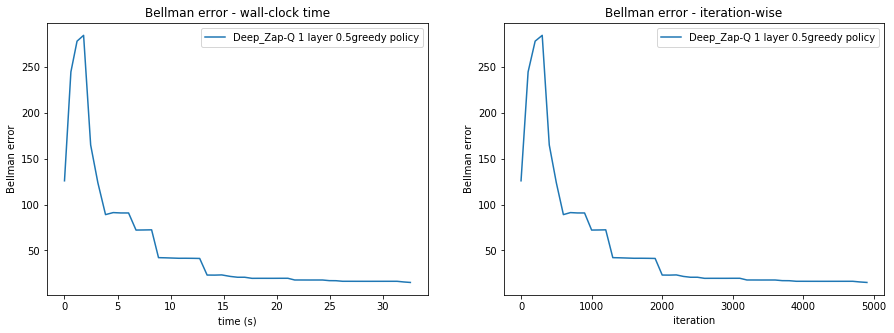

tensor([[305.0207,   0.0000,   0.0000,   0.0000, 375.0928,   0.0000],
        [  0.0000, 378.4735,   0.0000, 300.4659,   0.0000, 487.2532],
        [  0.0000,   0.0000, 214.0869, 277.1404,   0.0000,   0.0000],
        [  0.0000, 366.5984, 235.4637, 298.9819, 369.9656,   0.0000],
        [302.5720,   0.0000,   0.0000, 306.5596, 379.3898, 484.2846],
        [  0.0000, 384.6306,   0.0000,   0.0000, 383.1887, 493.8687]])


In [138]:
architecture = nn.Sequential(
    nn.Linear(num_SA, 1, bias=False)
)
for m in architecture.modules():
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 0)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot = True,
          dataplot=None,
          plotLabel='Deep_Zap-Q 1 layer 0.5greedy policy',
          architecture = architecture)

print(Q)

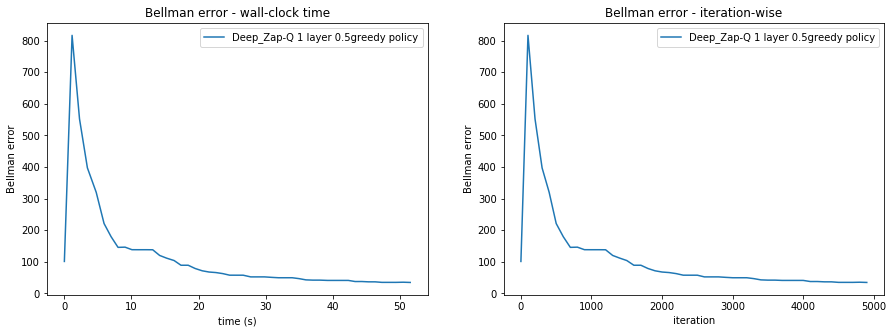

tensor([[300.0101,   0.0000,   0.0000,   0.0000, 370.0499,   0.0000],
        [  0.0000, 382.5563,   0.0000, 305.0754,   0.0000, 490.5346],
        [  0.0000,   0.0000, 219.6701, 281.4935,   0.0000,   0.0000],
        [  0.0000, 367.1830, 246.0305, 270.6897, 374.9727,   0.0000],
        [306.0481,   0.0000,   0.0000, 303.9930, 380.5169, 485.4052],
        [  0.0000, 386.2765,   0.0000,   0.0000, 384.0248, 495.2496]])


In [143]:
architecture = nn.Sequential(
    nn.Linear(num_SA, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)
for m in architecture.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot = True,
          dataplot=None,
          plotLabel='Deep_Zap-Q 1 layer 0.5greedy policy',
          architecture = architecture)

print(Q)

## Implementation of simple Zap Q

In [0]:
# defining the graph (weighted with rewards):

R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
              [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])

NumbertoSAPair = np.array([[0, 0],[0,4],
                           [1,1],[1,3],[1,5],
                           [2,2],[2,3],[3,1],[3,2],[3,3],
                           [3,4],[4,0],[4,3],[4,4],[4,5],
                           [5,1],[5,4],[5,5]])

AlenVec = np.array([2,3,2,4,4,3])

# Inverse mapping: Given state-action pair, what is the curresponding number:
SAPairtoNumber = -1*np.ones((6,6))

for i in range(len(NumbertoSAPair)):
    SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
    
StaActLen = np.sum(AlenVec); # Total number of state action pairs

In [0]:
def compute_Bellman_error(q_table, beta, noise):

    #Initialize Bellman error to 0:
    BE = np.zeros(StaActLen) # initialiser BE_Zap avec des 0
    
    for jj in range(StaActLen): # pour tous les state-action possibles

        x = NumbertoSAPair[jj,0] # x = state(jj)
        a = NumbertoSAPair[jj,1] # a = action(jj)

        # Calculate E[max_u Q(X_{t+1},u) | X_t=x, A_t = a]:
        max_Qfun_xtp1_Zap = 0; # max_Qfun_xtp1_Zap initialisé à 0
        NumOfXtp1 = 0; # NumOfXtp1 initialisé à 0
        for ll in range(StaActLen): # pour tous les state-action possibles ll
            if(NumbertoSAPair[ll,0] == x): # si ll part de state(jj)
                xplus1 = NumbertoSAPair[ll,1] # xplus1 prend action(ll)
                max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap + np.max(q_table[xplus1]) # max_Qfun_xtp1_Zap += max q_table à partir de action(ll)
                NumOfXtp1 = NumOfXtp1 + 1 # NumOfXtp1++
        max_Qfun_xtp1_Zap = max_Qfun_xtp1_Zap/NumOfXtp1 # max_Qfun_xtp1_Zap /= NumOfXtp1 (ie on prend l'average de toutes les greedy policies à partir de x)

        # BE(x,a) = R(x,a) + beta*E[max_u Q(X_{t+1},u) | X_t=x, A_t = a] - Q(x,a)
        BE[jj] = R[x,a] + beta*((1-noise)*np.max(q_table[a]) +  noise*max_Qfun_xtp1_Zap) - q_table[x,a]

    # MaximalBellmanError = max_{x,a} BE(x,a):  
    return np.max(abs(BE))

In [0]:
import math

def epsilon_greedy_policy(x, adjacencyMatrix, QTable, epsilon=0, environmentAwareness=False):
    """
    Returns action a (:= next wanted step in this problem)
    Takes greedy action with proba 1-epsilon
    adjacencyMatrix is the weighted reward matrix with -100 where no edges
    it will not be taken into account if environmentAwareness=False (then agent can choose -100 edges)
    """
    r = np.random.rand()
    if not environmentAwareness:
        if r > epsilon:
            return np.argmax(QTable[x])
        else:
            return np.random.choice(range(QTable[x].shape[0]))
    else:
        if r > epsilon:
            imax = -1
            Qmax = -1 * math.inf
            for i in range(QTable[x].shape[0]):
                if adjacencyMatrix[x][i] > -100 and QTable[x][i] > Qmax:
                    imax = i
                    Qmax = QTable[x][i]
            assert imax > -1, "Error : no possible action"
            return imax
        
        else:
            available = []
            for i in range(adjacencyMatrix[x].shape[0]):
                if adjacencyMatrix[x][i] > -100:
                    available.append(i)
            assert not len(available) == 0, "Error : no possible action"
            return np.random.choice(available)

In [0]:
def take_action(x, a, adjacencyMatrix, environmentAwareness=True, randomness=0.5):
    """
    Environment response to the action a from state x, returns: newState, reward
    when environmentAwareness=True, only possible actions will be randomly taken in case of random failure
    """
    #print('randomness:', randomness, 'received x:', x, 'received a:', a)
    r = np.random.rand()
    if not environmentAwareness:
        if r > randomness:
            #print('not environmentAwareness, r > rand')
            return a, adjacencyMatrix[x][a]
        else:
            #print('not environmentAwareness, r <= rand')
            aa = np.random.choice(range(adjacencyMatrix[x].shape[0]))
            return aa, adjacencyMatrix[x][aa]
    else:
        available = []
        for i in range(adjacencyMatrix[x].shape[0]):
            if adjacencyMatrix[x][i] > -100:
                available.append(i)
        assert not len(available) == 0, "Error : no possible action"
        if r > randomness:
            assert a in available, "Error : the action in not possible"
            #print('environmentAwareness, r > rand')
            return a, adjacencyMatrix[x][a]
        else:
            #print('environmentAwareness, r <= rand')
            aa = np.random.choice(available)
            return aa, adjacencyMatrix[x][aa]

In [0]:
def compute_max_real_part_eigenvalue(M): # computes the max real part of the eigenvalues of matrix M
    return np.max(np.real(np.linalg.eig(M)[0]))

In [0]:
# Zap Q algorithm:
def Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=5000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None,
          plotLabel='Zap_Q',
          dataplot=None,
          ylim1=None):
    """
    /!\: Not self-contained, will only work with R for now
    Plots every t_step iteration, on the go if livePlot=True (alterates wall-clock performance)
    policyRandomness : epsilon of epsilon greedy policy
    environmentRandomness : noise of environment (proba of going to a random state)
    """
    
    if not dataplot:
        dataplot = collections.defaultdict(PlotResults) # history of Bellman Errors to plot
    #dataplot2 = collections.defaultdict(list) # history of max eigenvalues of GA to plot
    
    xt = xStart; # start in state 0
    noise = environmentRandomness
    R = np.array([[0,-100,-100,-100,-5,-100],
              [-100,0,-100,-5,-100,100],
              [-100,-100,0,-5,-100,-100],
             [-100,-5,-5,0,-5,-100],
              [-5,-100,-100,-5,0,100],
              [-100,-5,-100,-100,-5,100]])
    
    AlenVec = np.array([2,3,2,4,4,3]) # Number of actions in each state; Ex: 2 = number of actions in state 0.

    # We need a mapping from state-action pair to a number between 1 and 18
    # This array is precisely that mapping
    # E.g. [State 0, Action 0] corresponds to the zeroeth state-action pair, 
    # [State 0, Action 4] corresponds to the first state-action pair

    NumbertoSAPair = np.array([[0, 0],[0,4],[1,1],[1,3],[1,5],
                               [2,2],[2,3],[3,1],[3,2],[3,3],
                               [3,4],[4,0],[4,3],[4,4],[4,5],
                               [5,1],[5,4],[5,5]])

    # Location of the state-action pair indicates the unique number which represents this pair (e.g. [5 5] = 17)

    # Inverse mapping: Given state-action pair, what is the curresponding number:
    SAPairtoNumber = -1*np.ones((6,6))

    for i in range(len(NumbertoSAPair)):
        SAPairtoNumber[NumbertoSAPair[i,0],NumbertoSAPair[i,1]]=i
        
    StaActLen = np.sum(AlenVec); # Total number of state action pairs

    # Initialize the Matrix gain for Zap Q:
    A_ZapQ = 10*np.eye(StaActLen)

    # Initialize the parameter vector for Zap Q:
    Qthetat_ZapQ = np.random.rand(StaActLen);

    # Initialize the Q function for Zap Q:
    Qfun_ZapQ = np.zeros((6,6))

    # Q-learning begins here:
    
    start_time = time.time()
    
    for t in range(T):
        
        if policyRandomness < 0:
            epsilon = 1./(t+1)
        else:
            epsilon = policyRandomness
        # ChooseAction will return the random action chosen in the current state AND the next state
        #xtp1at_m = ChooseAction(xt,noise,Qfun_ZapQ)
        at = epsilon_greedy_policy(xt,
                                   R,
                                   Qfun_ZapQ,
                                   epsilon=epsilon,
                                   environmentAwareness=policyEnvironmentAwareness)
        xtp1, _ = take_action(xt,
                              at,
                              R,
                              environmentAwareness=environmentEnvironmentAwareness,
                              randomness=environmentRandomness)
        #print(at)
        #print(xtp1)
        #break

        # Defining the stepsizes:
        alphat = 1./(t+2); # stepsize for parameter recursion
        gammat = np.power((t+1),-rho) # stepsize for matrix gain recursion

        num_sa_pair = int(SAPairtoNumber[xt][at]) # Mapping [S A] -> the curresponding number

        # Watkins' basis: Column vector with 1 at (x,a) and 0 elsewhere:
        psi = np.zeros(StaActLen)
        psi[num_sa_pair] = 1; # Basis are indicator functions

        # Watkins' basis evaluated at next state and the optimal policy:
        # Step 1: It takes values 1 at state-action pairs corresponding to xtp1, and all feasible actions
        psixtp1 = np.zeros(StaActLen)
        for jj in range(6):
            if SAPairtoNumber[xtp1,jj]>=0: # Is the action feasible?
                psixtp1[int(SAPairtoNumber[xtp1,jj])] = 1 # Take value 1


        # Zap Q-learning step:

        # Q(X_t,A_t):
        Qxt_Zap = np.dot(Qthetat_ZapQ,psi)

        # Q(X_t+1,a) with all feasible a's; Need to take minimum over all 'a' later:
        Qxtp1_Zap = np.multiply(Qthetat_ZapQ,psixtp1)

        # Optimal action for state xtp1, given the current parameter estimate:
        OptAct_xtp1 = np.argmax(Qxtp1_Zap)
        # Q-value at xtp1 and the optimal action:
        max_Qxtp1_Zap = np.max(Qxtp1_Zap)
        # max_Qxtp1_Zap = Qxtp1_Zap[OptAct_xtp1]

        # Basis function evaluated at xtp1 and the corresponding optimal action
        psixtp1_OptAct = np.zeros(StaActLen);
        psixtp1_OptAct[OptAct_xtp1] = 1;

        # Zap Q-learning begins here:

        # Estimating the A(\theta_t) matrix:
        A_ZapQ = A_ZapQ + gammat*( ( - np.outer(psi,psi) + beta*np.outer(psi,psixtp1_OptAct)) - A_ZapQ)
        Ainv_ZapQ = np.linalg.pinv(A_ZapQ)

        # Q update for SNR 2 (a) gain:
        Qthetat_ZapQ  =  Qthetat_ZapQ  - alphat*(np.dot(Ainv_ZapQ,psi))*((R[xt,at] + beta*max_Qxtp1_Zap - Qxt_Zap))

        # Zap Q-learning ends here



        xt = xtp1;

        # The code from here is to calculate the Bellman error at this iteration
        
        for jj in range(StaActLen):
            Qfun_ZapQ[NumbertoSAPair[jj,0],NumbertoSAPair[jj,1]] = Qthetat_ZapQ[jj]
        
        if((t%t_step)==0):
            # MaximalBellmanError = max_{x,a} BE(x,a):  
            dataplot[plotLabel].time.append(time.time() - start_time)
            dataplot[plotLabel].iteration.append(t)
            dataplot[plotLabel].data.append(compute_Bellman_error(Qfun_ZapQ, beta, noise))
            dataplot2[plotLabel].time.append(time.time() - start_time)
            dataplot2[plotLabel].iteration.append(t)
            dataplot2[plotLabel].data.append(compute_max_real_part_eigenvalue(A_ZapQ))
            #dataplot2['Zap_Q'].append(compute_max_real_part_eigenvalue(A_ZapQ))
            #dataplotMaxEV['Zap_Q'].append(compute_max_real_part_eigenvalue())
            if livePlot:
                live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='time (s)', ylim1=ylim1)

            # End of calculating Bellman Error
    #if not livePlot:
    #    live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return Qfun_ZapQ, dataplot

In [150]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=True,
          plotTitle=None,
          plotLabel='Zap_Q random policy',
          dataplot=dataplot)

print(Q)

[[308.3060216    0.           0.           0.         374.81196744
    0.        ]
 [  0.         385.38563864   0.         306.98182427   0.
  490.0339631 ]
 [  0.           0.         236.44667551 287.00282453   0.
    0.        ]
 [  0.         374.13104282 243.89950191 304.0030712  372.33345839
    0.        ]
 [303.946045     0.           0.         303.04476521 379.70411182
  486.16096978]
 [  0.         387.12407297   0.           0.         384.56154118
  495.78709729]]


In [0]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.9,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.9 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.5 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.1 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=-1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 1/t greedy policy',
          dataplot=dataplot)

print(Q)

[[309.66070131   0.           0.           0.         375.5007119
    0.        ]
 [  0.         385.61709542   0.         306.82018928   0.
  489.72735167]
 [  0.           0.         236.68453535 287.18500454   0.
    0.        ]
 [  0.         374.15936995 244.37151456 305.30018235 371.23777051
    0.        ]
 [304.43054665   0.           0.         302.93423485 379.90360712
  486.95529456]
 [  0.         386.83632429   0.           0.         385.14406432
  495.9153287 ]]
[[306.8047659    0.           0.           0.         374.45158898
    0.        ]
 [  0.         385.75147877   0.         306.20171257   0.
  489.19965946]
 [  0.           0.         234.58904251 286.16258518   0.
    0.        ]
 [  0.         373.25128764 244.22929571 304.98166591 371.84725016
    0.        ]
 [303.81033292   0.           0.         302.60014763 379.62874294
  486.22854779]
 [  0.         386.52142166   0.           0.         384.61584393
  495.56774809]]
[[300.52243399   0.           0.   

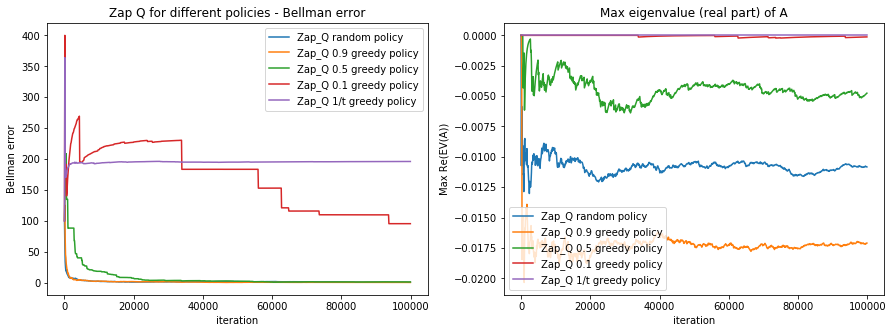

In [0]:
live_plot(dataplot,
          title='Zap Q for different policies - Bellman error',
          ylabel='Bellman error',
          xlabel='iteration',
          clock_time1=False,
          grid=False,
          data_dict2=dataplot2,
          title2='Max eigenvalue (real part) of A',
          ylabel2='Max Re(EV(A))',
          xlabel2='iteration',
          clock_time2=False)

In [0]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.8,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.8 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.7,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.7 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.6,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.6 greedy policy',
          dataplot=dataplot)

print(Q)


[[308.70988221   0.           0.           0.         375.53618131
    0.        ]
 [  0.         385.97769179   0.         305.81202686   0.
  490.08806592]
 [  0.           0.         235.48708528 286.50546777   0.
    0.        ]
 [  0.         372.94423474 245.14984432 304.34209331 371.88972126
    0.        ]
 [304.31321124   0.           0.         302.71386368 380.52391227
  485.95149208]
 [  0.         387.07687309   0.           0.         384.48634497
  495.7247046 ]]
[[309.51243822   0.           0.           0.         375.82500484
    0.        ]
 [  0.         385.23860392   0.         305.02535962   0.
  489.14966267]
 [  0.           0.         235.51704849 285.9531318    0.
    0.        ]
 [  0.         372.90459123 242.9195403  304.53710835 370.96658624
    0.        ]
 [304.72847589   0.           0.         302.8825216  380.38035956
  486.42068852]
 [  0.         386.52715801   0.           0.         384.75171875
  495.74840911]]
[[308.89603979   0.           0.  

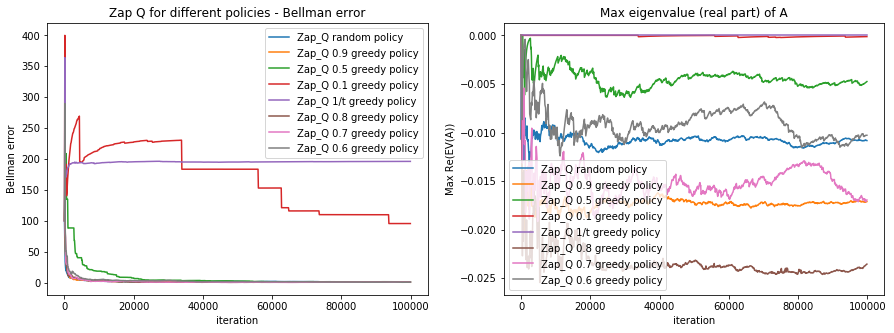

In [0]:
live_plot(dataplot,
          title='Zap Q for different policies - Bellman error',
          ylabel='Bellman error',
          xlabel='iteration',
          clock_time1=False,
          grid=False,
          data_dict2=dataplot2,
          title2='Max eigenvalue (real part) of A',
          ylabel2='Max Re(EV(A))',
          xlabel2='iteration',
          clock_time2=False)

In [0]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.4,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.4 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.3,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.3 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.2,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.2 greedy policy',
          dataplot=dataplot)

print(Q)


[[308.1657975    0.           0.           0.         374.6301368
    0.        ]
 [  0.         384.72315179   0.         306.00084535   0.
  488.81958234]
 [  0.           0.         237.42828673 287.47758325   0.
    0.        ]
 [  0.         373.87347803 244.8778354  301.27553027 371.998714
    0.        ]
 [302.4078518    0.           0.         302.25558151 380.01257845
  486.46692865]
 [  0.         386.07225771   0.           0.         384.69141176
  495.69626671]]
[[308.19795012   0.           0.           0.         375.40517977
    0.        ]
 [  0.         384.95133851   0.         306.32458952   0.
  489.42370978]
 [  0.           0.         232.55702679 286.78491027   0.
    0.        ]
 [  0.         373.55913859 243.63199064 303.35223935 370.47732289
    0.        ]
 [304.60096972   0.           0.         302.97621171 379.52656271
  486.68182444]
 [  0.         386.69007737   0.           0.         384.93359126
  495.88391407]]
[[307.19649069   0.           0.     

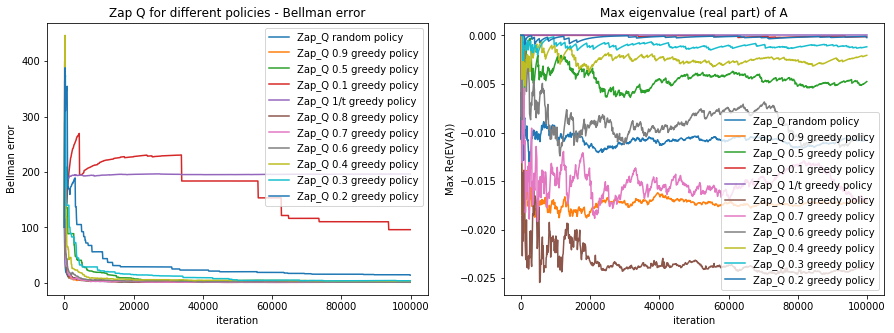

In [0]:
live_plot(dataplot,
          title='Zap Q for different policies - Bellman error',
          ylabel='Bellman error',
          xlabel='iteration',
          clock_time1=False,
          grid=False,
          data_dict2=dataplot2,
          title2='Max eigenvalue (real part) of A',
          ylabel2='Max Re(EV(A))',
          xlabel2='iteration',
          clock_time2=False)

In [0]:
dataplot = collections.defaultdict(PlotResults)
dataplot2 = collections.defaultdict(PlotResults)

In [0]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=1.0,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q random policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.9,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.9 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.8,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.8 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.7,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.7 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.6,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.6 greedy policy',
          dataplot=dataplot)

print(Q)


[[308.44721619   0.           0.           0.         374.40841346
    0.        ]
 [  0.         385.34245455   0.         306.37143423   0.
  489.0394764 ]
 [  0.           0.         236.03049203 286.61326837   0.
    0.        ]
 [  0.         373.49901339 243.50807964 305.64760394 371.88464145
    0.        ]
 [303.91306642   0.           0.         303.17415295 380.44376374
  486.18879417]
 [  0.         386.42250477   0.           0.         384.57697338
  495.23676404]]
[[309.2399451    0.           0.           0.         374.78958186
    0.        ]
 [  0.         385.51594408   0.         306.25799773   0.
  489.32691811]
 [  0.           0.         236.35651888 287.10229696   0.
    0.        ]
 [  0.         373.69596392 244.19579454 304.33704065 370.47621448
    0.        ]
 [304.39318207   0.           0.         303.19919147 380.0066446
  485.88800499]
 [  0.         386.53775468   0.           0.         384.39289174
  495.5177908 ]]
[[309.34481891   0.           0.   

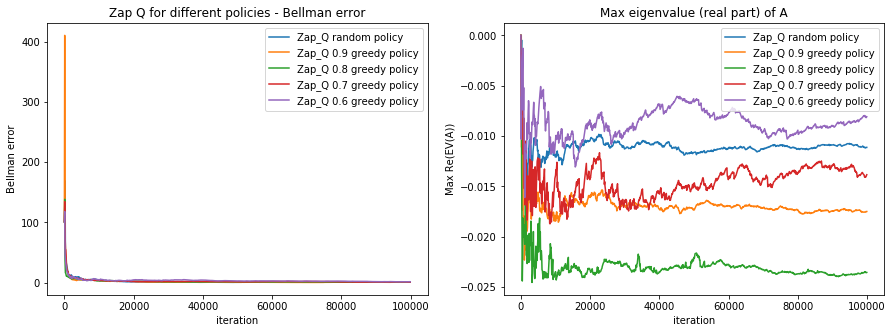

In [0]:
live_plot(dataplot,
          title='Zap Q for different policies - Bellman error',
          ylabel='Bellman error',
          xlabel='iteration',
          clock_time1=False,
          grid=False,
          data_dict2=dataplot2,
          title2='Max eigenvalue (real part) of A',
          ylabel2='Max Re(EV(A))',
          xlabel2='iteration',
          clock_time2=False)

In [0]:
dataplot = collections.defaultdict(PlotResults)
dataplot2 = collections.defaultdict(PlotResults)

In [0]:
Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.5,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.5 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.4,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.4 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.3,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.3 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.2,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.2 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0.1,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q 0.1 greedy policy',
          dataplot=dataplot)

print(Q)

Q, dataplot = Zap_Q(xStart = 4, # start state
          beta = 0.8, # Discount factor
          rho = 0.85, # Stepsize \gamma_n = (1/n)^\rhot_step=1000
          policyEnvironmentAwareness=True, # policy won't take impossible actions if True
          environmentEnvironmentAwareness=True, # environment will only return possible actions in case of failure if True
          policyRandomness=0,
          environmentRandomness=0.2,
          T=100000, # Number of iterations for learning (number of data samples we observe)
          t_step=100, #This is how often I want to store the data (Bellman error)
          livePlot=False,
          plotTitle=None,
          plotLabel='Zap_Q greedy policy',
          dataplot=dataplot)

print(Q)

[[309.19562158   0.           0.           0.         375.67651275
    0.        ]
 [  0.         385.40476655   0.         305.46259176   0.
  489.42622488]
 [  0.           0.         234.01414182 286.1887273    0.
    0.        ]
 [  0.         372.23356091 241.63957282 303.92623198 370.55644463
    0.        ]
 [304.77623994   0.           0.         301.4431373  380.909495
  487.07292746]
 [  0.         386.65265926   0.           0.         385.21610833
  495.93566986]]
[[307.98625741   0.           0.           0.         374.48791161
    0.        ]
 [  0.         385.10955855   0.         305.50460847   0.
  489.81251381]
 [  0.           0.         232.94815048 285.55467537   0.
    0.        ]
 [  0.         374.16865069 245.36596881 301.80011423 368.15985105
    0.        ]
 [303.32956489   0.           0.         302.60578557 380.02744974
  485.96717402]
 [  0.         386.92914194   0.           0.         384.38349285
  495.77034255]]
[[308.62991518   0.           0.    

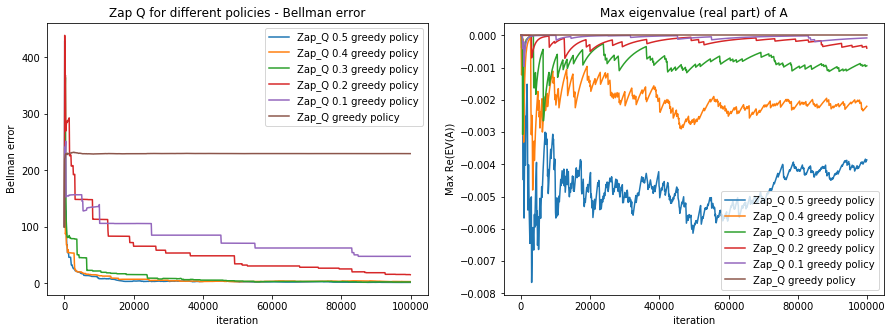

In [0]:
live_plot(dataplot,
          title='Zap Q for different policies - Bellman error',
          ylabel='Bellman error',
          xlabel='iteration',
          clock_time1=False,
          grid=False,
          data_dict2=dataplot2,
          title2='Max eigenvalue (real part) of A',
          ylabel2='Max Re(EV(A))',
          xlabel2='iteration',
          clock_time2=False)

## Implementation of vanilla Q learning

In [0]:
# vanilla Q learning :

def vanilla_Q_learning(livePlot=True,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 100000,
                       iter_max = 10,
                       policyRandomness = 0,
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       seed=0,
                       plotTitle=None,
                       dataplot=None,
                       plotLabel='Vanilla_Q'):
    np.random.seed(seed)
    BE = np.zeros((6,6))
    xt1 = 4
    if not dataplot:
        dataplot = collections.defaultdict(PlotResults)
    #dataplot = collections.defaultdict(list)
    #print ('----- using Q Learning -----')
    q_table = np.zeros((6,6))
    start_time = time.time()
    for i in range(iter_max):
        obs = xt1
        total_reward = 0
        for j in range(t_max):
            #alpha = 1/(j+1)
            alpha = max(min_lr, initial_lr * (0.85 ** (j//100)))
            xt0 = xt1
            #print('---\n state ', xt0)
            #print('qtable initiale \n', q_table)
            action = epsilon_greedy_policy(xt0,
                                   R,
                                   q_table,
                                   epsilon=policyRandomness,
                                   environmentAwareness=policyEnvironmentAwareness)
            #print('chosen action ', action)
            xt1, reward = take_action(xt0,
                                  action,
                                  R,
                                  environmentAwareness=environmentEnvironmentAwareness,
                                  randomness=environmentRandomness)
            #print('new state ', xt1, ', reward ', reward)
            total_reward += (gamma ** j) * reward
            # update q table
            q_table[xt0][action] = q_table[xt0][action] + alpha * (reward + gamma *  np.max(q_table[xt1]) - q_table[xt0][action])
            #print('qtable updated \n', q_table)
            if j%5000 == 0:
                dataplot[plotLabel].data.append(compute_Bellman_error(q_table, gamma, environmentRandomness))
                dataplot[plotLabel].iteration.append(i*t_max + j)
                dataplot[plotLabel].time.append(time.time() - start_time)
                if livePlot:
                    live_plot(dataplot, title=plotTitle, ylabel='Bellman error', xlabel='t')
    return q_table, dataplot

In [0]:
q_table, dataplot = vanilla_Q_learning(livePlot=False,
                       initial_lr = 1.0,
                       min_lr = 0.003,
                       gamma = 0.8,
                       t_max = 1300000, # one million iterations instead of 100 000
                       iter_max = 1, # one episode, we don't need to use episodes here
                       policyRandomness = 1, # full random
                       policyEnvironmentAwareness = True,
                       environmentEnvironmentAwareness = True,
                       environmentRandomness = 0.2,
                       plotTitle='Vanilla Q Learning - random policy',
                       dataplot = dataplot)

print(q_table)

[[261.4174014    0.           0.           0.         318.4690065
    0.        ]
 [  0.         336.74897569   0.         269.01044415   0.
  417.79776891]
 [  0.           0.         202.38000046 246.33246271   0.
    0.        ]
 [  0.         319.30349712 208.81513284 259.29621176 312.95903984
    0.        ]
 [263.30427354   0.           0.         263.41463968 328.99742832
  411.71507192]
 [  0.         335.76228536   0.           0.         332.84781925
  422.86453478]]


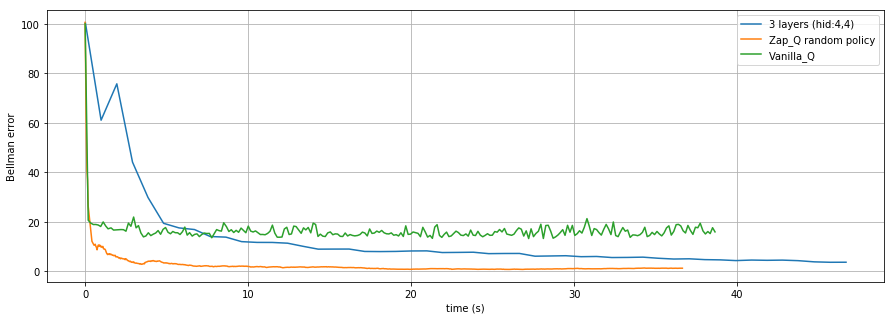

In [0]:
live_plot(dataplot, title=None, ylabel='Bellman error', xlabel='time (s)')

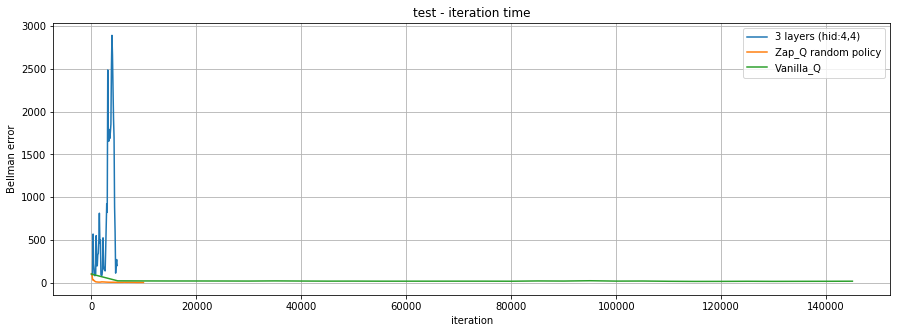

In [0]:
live_plot(dataplot, title='test - iteration time', ylabel='Bellman error', xlabel='iteration',clock_time1=False)